In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('sampleData', delimiter='\t', header=None)
print(df.shape)
print(df.columns)

(1615789, 90)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89],
           dtype='int64')


### Missing values [-1] and zero columns

In [3]:
missing_col_ids = []
zero_col_ids = []
for col_id in range(df.shape[1]):
    missing_percentage = df[df[col_id] == -1].shape[0] / float(df.shape[0])
    zero_percentage = df[df[col_id] == 0].shape[0] / float(df.shape[0])
    if missing_percentage == 1:
        missing_col_ids.append(col_id)
    if zero_percentage == 1:
        zero_col_ids.append(col_id)
print(missing_col_ids)
print(zero_col_ids)

[55, 56, 74]
[1, 6, 8, 14, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 35, 36, 38, 39, 41, 42, 50, 52, 57, 60, 66, 68, 69, 70, 71, 72, 73]


### Distributions of zeros

<Container object of 90 artists>

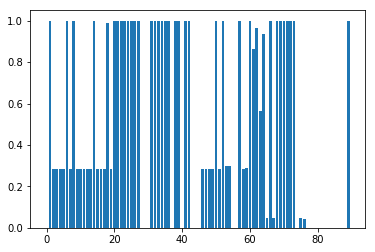

In [4]:
col_id_percentage = {}
for col_id in range(df.shape[1]):
    percentage = df[df[col_id] == 0].shape[0] / float(df.shape[0])
    col_id_percentage[col_id] = percentage
plt.bar(col_id_percentage.keys(), col_id_percentage.values())

## It indicates that there are many columns with all zeros(0) and all missing values(-1). Lets discard them

In [5]:
new_cols = list(set(df.columns) - set(zero_col_ids) - set(missing_col_ids))
df_new = df[new_cols]
print('Number of columns in the new dataframe: %s' % df_new.shape[1])

Number of columns in the new dataframe: 54


## After removing all zero columns

<Container object of 54 artists>

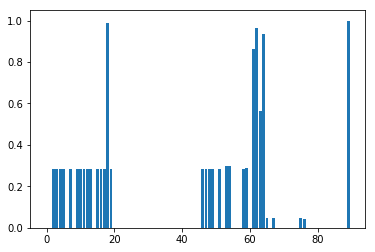

In [6]:
col_id_percentage = {}
for col_id in df_new.columns:
    percentage = df_new[df_new[col_id] == 0].shape[0] / float(df_new.shape[0])
    col_id_percentage[col_id] = percentage
plt.bar(col_id_percentage.keys(), col_id_percentage.values())

### Distribution of nulls : no null values

In [7]:
df.isnull().sum().sum()

0

### User Id observation : it is not a primary key, we cannot discard it

In [8]:
print('Total number of records: %s' %df_new.shape[0])
print('Total number of unique user ids %s' %len(df_new[0].unique()))

Total number of records: 1615789
Total number of unique user ids 120034


## This is totally imbalanced dataset

In [10]:
print(df_new[89].value_counts())
print('Percentage of class A(ones) ' + str(df_new[df_new[89] == 0].shape[0]/float(df_new.shape[0]) * 100))
print('Percentage of class B(zeros) ' + str(df_new[df_new[89] == 1].shape[0]/float(df_new.shape[0]) * 100))

0    1614664
1       1125
Name: 89, dtype: int64
Percentage of class A(ones) 99.93037457242251
Percentage of class B(zeros) 0.06962542757748691


## Percentage of missing values 

In [11]:
for col in df_new.columns:
    if df_new[df_new[col] == -1].shape[0] != 0:
        print(col, end='\t')
        print(df_new[df_new[col] == -1].shape[0], end = '\t')
        print(df_new[df_new[col] == -1].shape[0]/float(df_new.shape[0]))

53	456416	0.2824725258062779
54	456416	0.2824725258062779
59	1179	0.0007296744810120628


## Dummy Classifier

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import log_loss, f1_score, roc_curve, auc

In [14]:
for index in range(77, 88, 1):
    df_new.loc[:, index] = df_new[index].astype('category')

x = df_new.loc[:, 0:88]
y = df_new.loc[:, 89]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=44, stratify=y)
x_test, x_cv, y_test, y_cv = train_test_split(x_test, y_test, test_size=0.5, random_state=44, stratify=y_test)

categorical_features = list(df_new.loc[:, 77:88].columns)
train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgb.Dataset(x_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)
cv_data = lgb.Dataset(x_cv, label=y_cv, categorical_feature=categorical_features, free_raw_data=False)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
dummy_model = DummyClassifier()
dummy_model.fit(train_data.data, train_data.label)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [21]:
y_true = test_data.label
y_pred = dummy_model.predict_proba(test_data.data)

fpr, tpr, thresholds = roc_curve(test_data.label, y_pred[:, 1])
print(auc(fpr, tpr))
print(log_loss(y_true, y_pred[:, 1]))

0.49965163052397865
0.04809606844680288


## Logistic Classifier

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [14]:
df_new.to_csv('df_new.csv')

In [23]:
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(df_new.loc[:,77: 88])

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [26]:
df_small = df_new[df_new[89] == 0].sample(50000)
df_new_small = pd.concat([df_small, df_new[df_new[89] == 1]], axis=0)

In [27]:
df_new_small[89].value_counts()

0    50000
1     1125
Name: 89, dtype: int64

In [28]:
cat_df = pd.DataFrame(one_hot_encoder.transform(df_new_small.loc[:,77: 88]).toarray())

In [31]:
log_df = pd.concat([df_new_small.loc[:,0:76], cat_df], axis=0, ignore_index=True, copy=False)

In [32]:
print(cat_df.shape)
print(df_new_small.loc[:,0:76].shape)
print(log_df.shape) ##<--bug

(51125, 31455)
(51125, 41)
(102250, 31455)


### Aborting this path because of categorical variables. Once they are converted to numeric columns using onehotencoding, number of dimensions are getting increased and at the same time the data points are also huge in size.
### Also, the dataset is biased in class distribution, so we need to use undersample majority and over sample minority class.
### This can be handles easily using Tree(lightgbm) based approaches because of categorical variables.

In [ ]:
# x = log_df
# y = df_new.loc[:, 89]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=44, stratify=y)
# x_test, x_cv, y_test, y_cv = train_test_split(x_test, y_test, test_size=0.5, random_state=44, stratify=y_test)

# # categorical_features = list(df_new.loc[:, 77:88].columns)
# train_data = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
# test_data = lgb.Dataset(x_test, label=y_test, free_raw_data=False)
# cv_data = lgb.Dataset(x_cv, label=y_cv, free_raw_data=False)

In [ ]:
# lg_model = LogisticRegression()
# lg_model.fit(train_data.data, train_data.label)

In [ ]:
# y_pred = lg_model.predict_proba(test_data.data)
# print(y_pred)

In [ ]:
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
# clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)

In [33]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, f1_score, roc_curve, auc

In [34]:
# for index in range(77, 88, 1):
#     df_new.loc[:, index] = df_new[index].astype('category')

# x = df_new.loc[:, 0:88]
# y = df_new.loc[:, 89]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=44, stratify=y)
# x_test, x_cv, y_test, y_cv = train_test_split(x_test, y_test, test_size=0.5, random_state=44, stratify=y_test)

# categorical_features = list(df_new.loc[:, 77:88].columns)
# train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
# test_data = lgb.Dataset(x_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)
# cv_data = lgb.Dataset(x_cv, label=y_cv, categorical_feature=categorical_features, free_raw_data=False)

### Model initialization

In [35]:
parameters = {
#     'scale_pos_weight': 1000,
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.0009,
    'verbose': 100,
    'n_estimators': 150
}

# model = lightgbm.train(parameters,
#                        train_data,
#                        valid_sets=cv_data,
#                        num_boost_round=30,
#                        early_stopping_rounds=5)
model = lgb.LGBMClassifier(**parameters)
model.fit(train_data.data, train_data.label, eval_set=[(cv_data.data, cv_data.label)], early_stopping_rounds=10, eval_metric='binary_logloss')

##binary_logloss TODO

[1]	valid_0's binary_logloss: 0.00567437
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0057625
[3]	valid_0's binary_logloss: 0.0058534
[4]	valid_0's binary_logloss: 0.00595926
[5]	valid_0's binary_logloss: 0.00609264
[6]	valid_0's binary_logloss: 0.00622253
[7]	valid_0's binary_logloss: 0.00635518
[8]	valid_0's binary_logloss: 0.00650039
[9]	valid_0's binary_logloss: 0.00665638
[10]	valid_0's binary_logloss: 0.00681394
[11]	valid_0's binary_logloss: 0.00696483
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.00567437


LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
        boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.5, is_unbalance='true',
        learning_rate=0.0009, max_depth=-1, metric='binary_logloss',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=100)

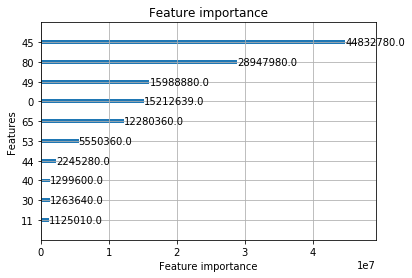

In [36]:
lgb.plot_importance(model, importance_type='gain', max_num_features=10)

In [37]:
y_pred = model.predict_proba(test_data.data)
print(y_pred)

[[9.98469113e-01 1.53088673e-03]
 [9.98469113e-01 1.53088673e-03]
 [9.99304259e-01 6.95740966e-04]
 ...
 [9.98248645e-01 1.75135466e-03]
 [9.99304372e-01 6.95628216e-04]
 [9.99229993e-01 7.70006910e-04]]


In [38]:
fpr, tpr, thresholds = roc_curve(test_data.label, y_pred[:, 1])#pos_label=1

In [39]:
thresholds

array([1.00238364e+00, 2.38364218e-03, 1.96555989e-03, 1.84295540e-03,
       1.78942008e-03, 1.75135466e-03, 1.70910418e-03, 1.69538230e-03,
       1.68350274e-03, 1.68161142e-03, 1.61441090e-03, 1.59393917e-03,
       1.53088673e-03, 1.22043762e-03, 1.13625326e-03, 1.04944684e-03,
       9.69524872e-04, 9.23839756e-04, 7.70006910e-04, 6.95754263e-04,
       6.95740966e-04, 6.95628216e-04])

In [40]:
auc(fpr, tpr)

0.7261447145727166

## Yet to explore the metrics on plots

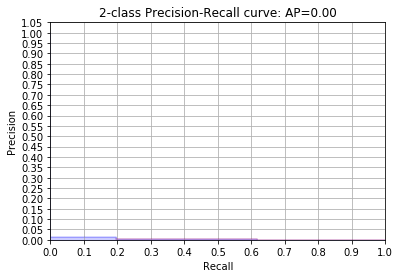

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from matplotlib.ticker import MultipleLocator
precision, recall, thresholds = precision_recall_curve(test_data.label, y_pred[:, 1])
average_precision = average_precision_score(test_data.label, y_pred[:, 1])

fig, ax = plt.subplots()
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.step(recall[:-1], thresholds, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.grid()

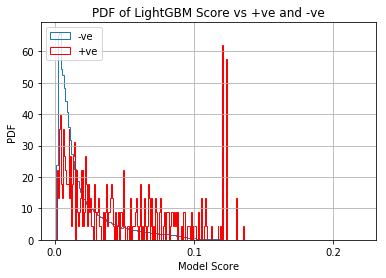

In [256]:
# Density plots
fig, ax = plt.subplots()
n_bins = 200

test_data.label, y_pred[:, 1]

y_test_proba = y_pred[:, 1]

n, bins, patches = ax.hist(y_test_proba[(test_data.label==0)], n_bins, normed=1, histtype='step', cumulative=False, label='-ve')
ax.hist(y_test_proba[(test_data.label==1)], n_bins, normed=1, histtype='step', cumulative=False, label='+ve', color='r')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(True)
ax.legend(loc='upper left')
ax.set_title('PDF of LightGBM Score vs +ve and -ve')
ax.set_xlabel('Model Score')
ax.set_ylabel('PDF')
#plt.savefig(fname)
plt.show()

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.15, 0.1, 0.01, 0.001],
    'feature_fraction': [0.55],
    'min_data_in_leaf': [5000], 
    'max_depth': [18],
    'num_leaves': [60],
    'n_estimators': [20],
    'scale_pos_weight': [3, 4, 5 ]
}

# parameters = {
# #     'scale_pos_weight': 1000,
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.0009,
#     'verbose': 100,
#     'n_estimators': 150
# }

estimator = lgb.LGBMClassifier(num_leaves=31)

model = GridSearchCV(estimator, param_grid)

In [51]:
model.fit(train_data.data, train_data.label, eval_set=[(cv_data.data, cv_data.label)], early_stopping_rounds=10, eval_metric='binary_logloss')

[1]	valid_0's binary_logloss: 0.00786862
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00758149
[3]	valid_0's binary_logloss: 0.00733697
[4]	valid_0's binary_logloss: 0.00715738
[5]	valid_0's binary_logloss: 0.00699535
[6]	valid_0's binary_logloss: 0.00685259
[7]	valid_0's binary_logloss: 0.00673164
[8]	valid_0's binary_logloss: 0.00664959
[9]	valid_0's binary_logloss: 0.00655688
[10]	valid_0's binary_logloss: 0.00647057
[11]	valid_0's binary_logloss: 0.00641671
[12]	valid_0's binary_logloss: 0.00635704
[13]	valid_0's binary_logloss: 0.00629879
[14]	valid_0's binary_logloss: 0.0062593
[15]	valid_0's binary_logloss: 0.00621923
[16]	valid_0's binary_logloss: 0.00618769
[17]	valid_0's binary_logloss: 0.00614921
[18]	valid_0's binary_logloss: 0.00610833
[19]	valid_0's binary_logloss: 0.00606811
[20]	valid_0's binary_logloss: 0.00603683
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00603683


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00783255
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00751988
[3]	valid_0's binary_logloss: 0.00727986
[4]	valid_0's binary_logloss: 0.00709451
[5]	valid_0's binary_logloss: 0.00693735
[6]	valid_0's binary_logloss: 0.00677501
[7]	valid_0's binary_logloss: 0.00664966
[8]	valid_0's binary_logloss: 0.00654559
[9]	valid_0's binary_logloss: 0.0064446
[10]	valid_0's binary_logloss: 0.00636128
[11]	valid_0's binary_logloss: 0.00629724
[12]	valid_0's binary_logloss: 0.00624167
[13]	valid_0's binary_logloss: 0.00618011
[14]	valid_0's binary_logloss: 0.0061404
[15]	valid_0's binary_logloss: 0.0061067
[16]	valid_0's binary_logloss: 0.00607656
[17]	valid_0's binary_logloss: 0.00604063
[18]	valid_0's binary_logloss: 0.00601492
[19]	valid_0's binary_logloss: 0.00600352
[20]	valid_0's binary_logloss: 0.00596634
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00596634


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00681715
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00666778
[3]	valid_0's binary_logloss: 0.00654423
[4]	valid_0's binary_logloss: 0.00646733
[5]	valid_0's binary_logloss: 0.00639371
[6]	valid_0's binary_logloss: 0.00632171
[7]	valid_0's binary_logloss: 0.00627169
[8]	valid_0's binary_logloss: 0.00622011
[9]	valid_0's binary_logloss: 0.00616438
[10]	valid_0's binary_logloss: 0.0061263
[11]	valid_0's binary_logloss: 0.00608273
[12]	valid_0's binary_logloss: 0.00605981
[13]	valid_0's binary_logloss: 0.00602886
[14]	valid_0's binary_logloss: 0.00600639
[15]	valid_0's binary_logloss: 0.00598602
[16]	valid_0's binary_logloss: 0.00594177
[17]	valid_0's binary_logloss: 0.00592964
[18]	valid_0's binary_logloss: 0.00591216
[19]	valid_0's binary_logloss: 0.00589281
[20]	valid_0's binary_logloss: 0.00587593
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00587593


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0168245
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.014463
[3]	valid_0's binary_logloss: 0.0127141
[4]	valid_0's binary_logloss: 0.0116032
[5]	valid_0's binary_logloss: 0.0107549
[6]	valid_0's binary_logloss: 0.00999413
[7]	valid_0's binary_logloss: 0.00939772
[8]	valid_0's binary_logloss: 0.00897837
[9]	valid_0's binary_logloss: 0.00858412
[10]	valid_0's binary_logloss: 0.00829109
[11]	valid_0's binary_logloss: 0.00804606
[12]	valid_0's binary_logloss: 0.00781111
[13]	valid_0's binary_logloss: 0.00760654
[14]	valid_0's binary_logloss: 0.00747441
[15]	valid_0's binary_logloss: 0.00732878
[16]	valid_0's binary_logloss: 0.00718785
[17]	valid_0's binary_logloss: 0.00706731
[18]	valid_0's binary_logloss: 0.00696224
[19]	valid_0's binary_logloss: 0.00689756
[20]	valid_0's binary_logloss: 0.00681352
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00681352


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0163881
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0142516
[3]	valid_0's binary_logloss: 0.0125999
[4]	valid_0's binary_logloss: 0.0115409
[5]	valid_0's binary_logloss: 0.0107224
[6]	valid_0's binary_logloss: 0.00998786
[7]	valid_0's binary_logloss: 0.00939928
[8]	valid_0's binary_logloss: 0.00897722
[9]	valid_0's binary_logloss: 0.00858086
[10]	valid_0's binary_logloss: 0.00829138
[11]	valid_0's binary_logloss: 0.00805676
[12]	valid_0's binary_logloss: 0.00780794
[13]	valid_0's binary_logloss: 0.00760721
[14]	valid_0's binary_logloss: 0.00746486
[15]	valid_0's binary_logloss: 0.00731451
[16]	valid_0's binary_logloss: 0.00719121
[17]	valid_0's binary_logloss: 0.00707396
[18]	valid_0's binary_logloss: 0.00699292
[19]	valid_0's binary_logloss: 0.00691179
[20]	valid_0's binary_logloss: 0.00681817
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00681817


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0115828
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0107489
[3]	valid_0's binary_logloss: 0.0100563
[4]	valid_0's binary_logloss: 0.00952389
[5]	valid_0's binary_logloss: 0.00907919
[6]	valid_0's binary_logloss: 0.0087067
[7]	valid_0's binary_logloss: 0.00837277
[8]	valid_0's binary_logloss: 0.00811136
[9]	valid_0's binary_logloss: 0.00785393
[10]	valid_0's binary_logloss: 0.00767421
[11]	valid_0's binary_logloss: 0.00750517
[12]	valid_0's binary_logloss: 0.00735879
[13]	valid_0's binary_logloss: 0.00723023
[14]	valid_0's binary_logloss: 0.00710977
[15]	valid_0's binary_logloss: 0.0070138
[16]	valid_0's binary_logloss: 0.00692659
[17]	valid_0's binary_logloss: 0.00685136
[18]	valid_0's binary_logloss: 0.00679828
[19]	valid_0's binary_logloss: 0.00673534
[20]	valid_0's binary_logloss: 0.00666033
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00666033


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0335965
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0208446
[3]	valid_0's binary_logloss: 0.0169361
[4]	valid_0's binary_logloss: 0.0149743
[5]	valid_0's binary_logloss: 0.0135458
[6]	valid_0's binary_logloss: 0.0122912
[7]	valid_0's binary_logloss: 0.0113498
[8]	valid_0's binary_logloss: 0.0106819
[9]	valid_0's binary_logloss: 0.0100633
[10]	valid_0's binary_logloss: 0.00962817
[11]	valid_0's binary_logloss: 0.00928219
[12]	valid_0's binary_logloss: 0.00893172
[13]	valid_0's binary_logloss: 0.00867413
[14]	valid_0's binary_logloss: 0.00844995
[15]	valid_0's binary_logloss: 0.00822957
[16]	valid_0's binary_logloss: 0.00805447
[17]	valid_0's binary_logloss: 0.00787587
[18]	valid_0's binary_logloss: 0.00774791
[19]	valid_0's binary_logloss: 0.00764162
[20]	valid_0's binary_logloss: 0.00752312
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00752312


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0331843
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.02169
[3]	valid_0's binary_logloss: 0.0176503
[4]	valid_0's binary_logloss: 0.0155386
[5]	valid_0's binary_logloss: 0.0139976
[6]	valid_0's binary_logloss: 0.0126798
[7]	valid_0's binary_logloss: 0.0116697
[8]	valid_0's binary_logloss: 0.0109512
[9]	valid_0's binary_logloss: 0.0102851
[10]	valid_0's binary_logloss: 0.00980445
[11]	valid_0's binary_logloss: 0.00940433
[12]	valid_0's binary_logloss: 0.00903484
[13]	valid_0's binary_logloss: 0.00875474
[14]	valid_0's binary_logloss: 0.00853224
[15]	valid_0's binary_logloss: 0.00834155
[16]	valid_0's binary_logloss: 0.00816655
[17]	valid_0's binary_logloss: 0.00798436
[18]	valid_0's binary_logloss: 0.00783793
[19]	valid_0's binary_logloss: 0.00770988
[20]	valid_0's binary_logloss: 0.00758215
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00758215


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0275756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0228744
[3]	valid_0's binary_logloss: 0.0195067
[4]	valid_0's binary_logloss: 0.0172701
[5]	valid_0's binary_logloss: 0.0155327
[6]	valid_0's binary_logloss: 0.014106
[7]	valid_0's binary_logloss: 0.0129378
[8]	valid_0's binary_logloss: 0.0120317
[9]	valid_0's binary_logloss: 0.0112469
[10]	valid_0's binary_logloss: 0.0106268
[11]	valid_0's binary_logloss: 0.0101021
[12]	valid_0's binary_logloss: 0.00964828
[13]	valid_0's binary_logloss: 0.00925225
[14]	valid_0's binary_logloss: 0.00893059
[15]	valid_0's binary_logloss: 0.00867253
[16]	valid_0's binary_logloss: 0.00843569
[17]	valid_0's binary_logloss: 0.00822831
[18]	valid_0's binary_logloss: 0.00804939
[19]	valid_0's binary_logloss: 0.00789845
[20]	valid_0's binary_logloss: 0.00772795
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00772795


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00579156
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574799
[3]	valid_0's binary_logloss: 0.00570598
[4]	valid_0's binary_logloss: 0.0057021
[5]	valid_0's binary_logloss: 0.0056958
[6]	valid_0's binary_logloss: 0.00570777
[7]	valid_0's binary_logloss: 0.00571819
[8]	valid_0's binary_logloss: 0.00572431
[9]	valid_0's binary_logloss: 0.00572351
[10]	valid_0's binary_logloss: 0.005733
[11]	valid_0's binary_logloss: 0.00573386
[12]	valid_0's binary_logloss: 0.00574045
[13]	valid_0's binary_logloss: 0.00574493
[14]	valid_0's binary_logloss: 0.00574389
[15]	valid_0's binary_logloss: 0.00575112
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0056958


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00579064
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00576456
[3]	valid_0's binary_logloss: 0.00573736
[4]	valid_0's binary_logloss: 0.00572975
[5]	valid_0's binary_logloss: 0.00573373
[6]	valid_0's binary_logloss: 0.00572142
[7]	valid_0's binary_logloss: 0.00570885
[8]	valid_0's binary_logloss: 0.00570256
[9]	valid_0's binary_logloss: 0.00569667
[10]	valid_0's binary_logloss: 0.0057046
[11]	valid_0's binary_logloss: 0.00570395
[12]	valid_0's binary_logloss: 0.00570103
[13]	valid_0's binary_logloss: 0.00570447
[14]	valid_0's binary_logloss: 0.00570116
[15]	valid_0's binary_logloss: 0.00570861
[16]	valid_0's binary_logloss: 0.00570568
[17]	valid_0's binary_logloss: 0.00570407
[18]	valid_0's binary_logloss: 0.00570819
[19]	valid_0's binary_logloss: 0.00570951
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.00569667


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0056916
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00566081
[3]	valid_0's binary_logloss: 0.00565234
[4]	valid_0's binary_logloss: 0.00565697
[5]	valid_0's binary_logloss: 0.00566633
[6]	valid_0's binary_logloss: 0.0056724
[7]	valid_0's binary_logloss: 0.00567227
[8]	valid_0's binary_logloss: 0.00568547
[9]	valid_0's binary_logloss: 0.00568458
[10]	valid_0's binary_logloss: 0.00569042
[11]	valid_0's binary_logloss: 0.00568492
[12]	valid_0's binary_logloss: 0.00568868
[13]	valid_0's binary_logloss: 0.00569702
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.00565234


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00676756
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00667228
[3]	valid_0's binary_logloss: 0.00659405
[4]	valid_0's binary_logloss: 0.00657937
[5]	valid_0's binary_logloss: 0.0065701
[6]	valid_0's binary_logloss: 0.00655354
[7]	valid_0's binary_logloss: 0.00652649
[8]	valid_0's binary_logloss: 0.00651781
[9]	valid_0's binary_logloss: 0.0065013
[10]	valid_0's binary_logloss: 0.00648466
[11]	valid_0's binary_logloss: 0.00646109
[12]	valid_0's binary_logloss: 0.0064425
[13]	valid_0's binary_logloss: 0.00642674
[14]	valid_0's binary_logloss: 0.00641576
[15]	valid_0's binary_logloss: 0.00639979
[16]	valid_0's binary_logloss: 0.00638855
[17]	valid_0's binary_logloss: 0.00638005
[18]	valid_0's binary_logloss: 0.00636119
[19]	valid_0's binary_logloss: 0.00634356
[20]	valid_0's binary_logloss: 0.00631772
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00631772


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00670279
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00665314
[3]	valid_0's binary_logloss: 0.00658552
[4]	valid_0's binary_logloss: 0.00654771
[5]	valid_0's binary_logloss: 0.00654649
[6]	valid_0's binary_logloss: 0.00652882
[7]	valid_0's binary_logloss: 0.00650887
[8]	valid_0's binary_logloss: 0.00647922
[9]	valid_0's binary_logloss: 0.00645709
[10]	valid_0's binary_logloss: 0.00644369
[11]	valid_0's binary_logloss: 0.00642573
[12]	valid_0's binary_logloss: 0.00641167
[13]	valid_0's binary_logloss: 0.0063976
[14]	valid_0's binary_logloss: 0.00638063
[15]	valid_0's binary_logloss: 0.00637434
[16]	valid_0's binary_logloss: 0.0063599
[17]	valid_0's binary_logloss: 0.00634717
[18]	valid_0's binary_logloss: 0.00633855
[19]	valid_0's binary_logloss: 0.00632836
[20]	valid_0's binary_logloss: 0.00630853
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00630853


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00616377
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00617574
[3]	valid_0's binary_logloss: 0.00616235
[4]	valid_0's binary_logloss: 0.0061559
[5]	valid_0's binary_logloss: 0.00616354
[6]	valid_0's binary_logloss: 0.00618664
[7]	valid_0's binary_logloss: 0.00620298
[8]	valid_0's binary_logloss: 0.00622019
[9]	valid_0's binary_logloss: 0.00623199
[10]	valid_0's binary_logloss: 0.00622801
[11]	valid_0's binary_logloss: 0.00623149
[12]	valid_0's binary_logloss: 0.00624226
[13]	valid_0's binary_logloss: 0.00624794
[14]	valid_0's binary_logloss: 0.00624153
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.0061559


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00965654
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00933234
[3]	valid_0's binary_logloss: 0.00902715
[4]	valid_0's binary_logloss: 0.00882288
[5]	valid_0's binary_logloss: 0.00862108
[6]	valid_0's binary_logloss: 0.00843117
[7]	valid_0's binary_logloss: 0.00825775
[8]	valid_0's binary_logloss: 0.00812966
[9]	valid_0's binary_logloss: 0.00799639
[10]	valid_0's binary_logloss: 0.007896
[11]	valid_0's binary_logloss: 0.00781464
[12]	valid_0's binary_logloss: 0.00772347
[13]	valid_0's binary_logloss: 0.00764971
[14]	valid_0's binary_logloss: 0.00758399
[15]	valid_0's binary_logloss: 0.0075029
[16]	valid_0's binary_logloss: 0.0074258
[17]	valid_0's binary_logloss: 0.00734274
[18]	valid_0's binary_logloss: 0.00728309
[19]	valid_0's binary_logloss: 0.00723843
[20]	valid_0's binary_logloss: 0.00718431
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00718431


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00945103
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00913715
[3]	valid_0's binary_logloss: 0.00887092
[4]	valid_0's binary_logloss: 0.00862854
[5]	valid_0's binary_logloss: 0.00846368
[6]	valid_0's binary_logloss: 0.0082832
[7]	valid_0's binary_logloss: 0.00814011
[8]	valid_0's binary_logloss: 0.00803087
[9]	valid_0's binary_logloss: 0.00790017
[10]	valid_0's binary_logloss: 0.00781385
[11]	valid_0's binary_logloss: 0.00774072
[12]	valid_0's binary_logloss: 0.00765071
[13]	valid_0's binary_logloss: 0.00759448
[14]	valid_0's binary_logloss: 0.00754341
[15]	valid_0's binary_logloss: 0.00749029
[16]	valid_0's binary_logloss: 0.00742038
[17]	valid_0's binary_logloss: 0.00735315
[18]	valid_0's binary_logloss: 0.00729806
[19]	valid_0's binary_logloss: 0.0072464
[20]	valid_0's binary_logloss: 0.00719088
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00719088


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00796382
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00783317
[3]	valid_0's binary_logloss: 0.0077532
[4]	valid_0's binary_logloss: 0.00768271
[5]	valid_0's binary_logloss: 0.00761128
[6]	valid_0's binary_logloss: 0.00756181
[7]	valid_0's binary_logloss: 0.00749799
[8]	valid_0's binary_logloss: 0.0074343
[9]	valid_0's binary_logloss: 0.00737666
[10]	valid_0's binary_logloss: 0.00732837
[11]	valid_0's binary_logloss: 0.00727909
[12]	valid_0's binary_logloss: 0.00723424
[13]	valid_0's binary_logloss: 0.00719683
[14]	valid_0's binary_logloss: 0.00715724
[15]	valid_0's binary_logloss: 0.00712125
[16]	valid_0's binary_logloss: 0.00709637
[17]	valid_0's binary_logloss: 0.00706578
[18]	valid_0's binary_logloss: 0.00704073
[19]	valid_0's binary_logloss: 0.00700478
[20]	valid_0's binary_logloss: 0.00696719
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00696719


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00571969
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00568639
[3]	valid_0's binary_logloss: 0.00565977
[4]	valid_0's binary_logloss: 0.00563319
[5]	valid_0's binary_logloss: 0.00560269
[6]	valid_0's binary_logloss: 0.00558652
[7]	valid_0's binary_logloss: 0.00557006
[8]	valid_0's binary_logloss: 0.00554255
[9]	valid_0's binary_logloss: 0.00552835
[10]	valid_0's binary_logloss: 0.00551154
[11]	valid_0's binary_logloss: 0.00550132
[12]	valid_0's binary_logloss: 0.00548794
[13]	valid_0's binary_logloss: 0.00548074
[14]	valid_0's binary_logloss: 0.0054671
[15]	valid_0's binary_logloss: 0.0054582
[16]	valid_0's binary_logloss: 0.00544667
[17]	valid_0's binary_logloss: 0.00543476
[18]	valid_0's binary_logloss: 0.00542368
[19]	valid_0's binary_logloss: 0.00541533
[20]	valid_0's binary_logloss: 0.00540899
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00540899


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0057177
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0056871
[3]	valid_0's binary_logloss: 0.00565851
[4]	valid_0's binary_logloss: 0.00563366
[5]	valid_0's binary_logloss: 0.00560475
[6]	valid_0's binary_logloss: 0.00558772
[7]	valid_0's binary_logloss: 0.00557214
[8]	valid_0's binary_logloss: 0.00554273
[9]	valid_0's binary_logloss: 0.00552418
[10]	valid_0's binary_logloss: 0.00550528
[11]	valid_0's binary_logloss: 0.00549102
[12]	valid_0's binary_logloss: 0.00548137
[13]	valid_0's binary_logloss: 0.00546963
[14]	valid_0's binary_logloss: 0.00545891
[15]	valid_0's binary_logloss: 0.00544968
[16]	valid_0's binary_logloss: 0.00543918
[17]	valid_0's binary_logloss: 0.00543035
[18]	valid_0's binary_logloss: 0.00542109
[19]	valid_0's binary_logloss: 0.00541638
[20]	valid_0's binary_logloss: 0.00540972
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00540972


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00571743
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00568445
[3]	valid_0's binary_logloss: 0.00563633
[4]	valid_0's binary_logloss: 0.00560726
[5]	valid_0's binary_logloss: 0.0055792
[6]	valid_0's binary_logloss: 0.00556175
[7]	valid_0's binary_logloss: 0.00553823
[8]	valid_0's binary_logloss: 0.00551247
[9]	valid_0's binary_logloss: 0.00549745
[10]	valid_0's binary_logloss: 0.00548044
[11]	valid_0's binary_logloss: 0.0054636
[12]	valid_0's binary_logloss: 0.00545325
[13]	valid_0's binary_logloss: 0.00544243
[14]	valid_0's binary_logloss: 0.00543402
[15]	valid_0's binary_logloss: 0.00542745
[16]	valid_0's binary_logloss: 0.00541771
[17]	valid_0's binary_logloss: 0.00541084
[18]	valid_0's binary_logloss: 0.0054032
[19]	valid_0's binary_logloss: 0.00539657
[20]	valid_0's binary_logloss: 0.00538843
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00538843


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00571018
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00567047
[3]	valid_0's binary_logloss: 0.00564177
[4]	valid_0's binary_logloss: 0.00561147
[5]	valid_0's binary_logloss: 0.00557783
[6]	valid_0's binary_logloss: 0.00556177
[7]	valid_0's binary_logloss: 0.00554699
[8]	valid_0's binary_logloss: 0.00552004
[9]	valid_0's binary_logloss: 0.0055023
[10]	valid_0's binary_logloss: 0.00548667
[11]	valid_0's binary_logloss: 0.00547571
[12]	valid_0's binary_logloss: 0.00546844
[13]	valid_0's binary_logloss: 0.00546012
[14]	valid_0's binary_logloss: 0.00545623
[15]	valid_0's binary_logloss: 0.00545039
[16]	valid_0's binary_logloss: 0.00544245
[17]	valid_0's binary_logloss: 0.00543467
[18]	valid_0's binary_logloss: 0.00542767
[19]	valid_0's binary_logloss: 0.00542258
[20]	valid_0's binary_logloss: 0.00541909
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00541909


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00570806
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0056703
[3]	valid_0's binary_logloss: 0.00563907
[4]	valid_0's binary_logloss: 0.00560921
[5]	valid_0's binary_logloss: 0.00557787
[6]	valid_0's binary_logloss: 0.00556116
[7]	valid_0's binary_logloss: 0.00554634
[8]	valid_0's binary_logloss: 0.00551809
[9]	valid_0's binary_logloss: 0.00549991
[10]	valid_0's binary_logloss: 0.00548286
[11]	valid_0's binary_logloss: 0.00546819
[12]	valid_0's binary_logloss: 0.00546012
[13]	valid_0's binary_logloss: 0.00545318
[14]	valid_0's binary_logloss: 0.00544485
[15]	valid_0's binary_logloss: 0.00543884
[16]	valid_0's binary_logloss: 0.00543089
[17]	valid_0's binary_logloss: 0.00542582
[18]	valid_0's binary_logloss: 0.0054196
[19]	valid_0's binary_logloss: 0.00541526
[20]	valid_0's binary_logloss: 0.00541068
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00541068


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00570643
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00566562
[3]	valid_0's binary_logloss: 0.00561761
[4]	valid_0's binary_logloss: 0.00558556
[5]	valid_0's binary_logloss: 0.0055663
[6]	valid_0's binary_logloss: 0.00554833
[7]	valid_0's binary_logloss: 0.0055315
[8]	valid_0's binary_logloss: 0.00550467
[9]	valid_0's binary_logloss: 0.00548594
[10]	valid_0's binary_logloss: 0.00547028
[11]	valid_0's binary_logloss: 0.00545739
[12]	valid_0's binary_logloss: 0.00544486
[13]	valid_0's binary_logloss: 0.0054385
[14]	valid_0's binary_logloss: 0.00542855
[15]	valid_0's binary_logloss: 0.00542267
[16]	valid_0's binary_logloss: 0.00541392
[17]	valid_0's binary_logloss: 0.00540969
[18]	valid_0's binary_logloss: 0.00540472
[19]	valid_0's binary_logloss: 0.00540059
[20]	valid_0's binary_logloss: 0.00539642
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00539642


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00569613
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00564904
[3]	valid_0's binary_logloss: 0.00561979
[4]	valid_0's binary_logloss: 0.00558764
[5]	valid_0's binary_logloss: 0.00555073
[6]	valid_0's binary_logloss: 0.00553211
[7]	valid_0's binary_logloss: 0.00551102
[8]	valid_0's binary_logloss: 0.0054876
[9]	valid_0's binary_logloss: 0.00547309
[10]	valid_0's binary_logloss: 0.00546093
[11]	valid_0's binary_logloss: 0.00545166
[12]	valid_0's binary_logloss: 0.00545015
[13]	valid_0's binary_logloss: 0.00544618
[14]	valid_0's binary_logloss: 0.00543873
[15]	valid_0's binary_logloss: 0.00543755
[16]	valid_0's binary_logloss: 0.00543493
[17]	valid_0's binary_logloss: 0.00542928
[18]	valid_0's binary_logloss: 0.00542578
[19]	valid_0's binary_logloss: 0.00542469
[20]	valid_0's binary_logloss: 0.00542286
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00542286


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0056975
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00565292
[3]	valid_0's binary_logloss: 0.00562142
[4]	valid_0's binary_logloss: 0.00559084
[5]	valid_0's binary_logloss: 0.00555734
[6]	valid_0's binary_logloss: 0.00554188
[7]	valid_0's binary_logloss: 0.00551888
[8]	valid_0's binary_logloss: 0.0054934
[9]	valid_0's binary_logloss: 0.00547703
[10]	valid_0's binary_logloss: 0.00546396
[11]	valid_0's binary_logloss: 0.00545301
[12]	valid_0's binary_logloss: 0.00544934
[13]	valid_0's binary_logloss: 0.00544753
[14]	valid_0's binary_logloss: 0.00544253
[15]	valid_0's binary_logloss: 0.00543852
[16]	valid_0's binary_logloss: 0.00543505
[17]	valid_0's binary_logloss: 0.00543195
[18]	valid_0's binary_logloss: 0.00543035
[19]	valid_0's binary_logloss: 0.00543318
[20]	valid_0's binary_logloss: 0.00543102
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.00543035


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00569205
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00564245
[3]	valid_0's binary_logloss: 0.00559062
[4]	valid_0's binary_logloss: 0.00555958
[5]	valid_0's binary_logloss: 0.00554253
[6]	valid_0's binary_logloss: 0.0055258
[7]	valid_0's binary_logloss: 0.00551249
[8]	valid_0's binary_logloss: 0.0054879
[9]	valid_0's binary_logloss: 0.00547134
[10]	valid_0's binary_logloss: 0.00545907
[11]	valid_0's binary_logloss: 0.00545031
[12]	valid_0's binary_logloss: 0.00544362
[13]	valid_0's binary_logloss: 0.00544165
[14]	valid_0's binary_logloss: 0.00543811
[15]	valid_0's binary_logloss: 0.00543589
[16]	valid_0's binary_logloss: 0.00543133
[17]	valid_0's binary_logloss: 0.00542909
[18]	valid_0's binary_logloss: 0.00542704
[19]	valid_0's binary_logloss: 0.00542529
[20]	valid_0's binary_logloss: 0.00542357
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00542357


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00575373
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574997
[3]	valid_0's binary_logloss: 0.00574595
[4]	valid_0's binary_logloss: 0.00574184
[5]	valid_0's binary_logloss: 0.00573751
[6]	valid_0's binary_logloss: 0.00573408
[7]	valid_0's binary_logloss: 0.00573079
[8]	valid_0's binary_logloss: 0.00572716
[9]	valid_0's binary_logloss: 0.00572363
[10]	valid_0's binary_logloss: 0.00572017
[11]	valid_0's binary_logloss: 0.00571577
[12]	valid_0's binary_logloss: 0.00571319
[13]	valid_0's binary_logloss: 0.00571043
[14]	valid_0's binary_logloss: 0.00570621
[15]	valid_0's binary_logloss: 0.00570259
[16]	valid_0's binary_logloss: 0.00569803
[17]	valid_0's binary_logloss: 0.00569492
[18]	valid_0's binary_logloss: 0.00569064
[19]	valid_0's binary_logloss: 0.00568709
[20]	valid_0's binary_logloss: 0.00568298
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00568298


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00575352
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00575015
[3]	valid_0's binary_logloss: 0.00574621
[4]	valid_0's binary_logloss: 0.00574202
[5]	valid_0's binary_logloss: 0.00573727
[6]	valid_0's binary_logloss: 0.00573426
[7]	valid_0's binary_logloss: 0.00573084
[8]	valid_0's binary_logloss: 0.00572709
[9]	valid_0's binary_logloss: 0.00572384
[10]	valid_0's binary_logloss: 0.00572021
[11]	valid_0's binary_logloss: 0.00571575
[12]	valid_0's binary_logloss: 0.00571297
[13]	valid_0's binary_logloss: 0.00570946
[14]	valid_0's binary_logloss: 0.00570606
[15]	valid_0's binary_logloss: 0.0057024
[16]	valid_0's binary_logloss: 0.00569776
[17]	valid_0's binary_logloss: 0.00569459
[18]	valid_0's binary_logloss: 0.00569033
[19]	valid_0's binary_logloss: 0.00568691
[20]	valid_0's binary_logloss: 0.00568297
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00568297


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00575349
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574983
[3]	valid_0's binary_logloss: 0.00574556
[4]	valid_0's binary_logloss: 0.00574121
[5]	valid_0's binary_logloss: 0.00573633
[6]	valid_0's binary_logloss: 0.00573297
[7]	valid_0's binary_logloss: 0.00572944
[8]	valid_0's binary_logloss: 0.00572583
[9]	valid_0's binary_logloss: 0.00572236
[10]	valid_0's binary_logloss: 0.005719
[11]	valid_0's binary_logloss: 0.00571405
[12]	valid_0's binary_logloss: 0.00571121
[13]	valid_0's binary_logloss: 0.00570799
[14]	valid_0's binary_logloss: 0.00570392
[15]	valid_0's binary_logloss: 0.00570047
[16]	valid_0's binary_logloss: 0.00569602
[17]	valid_0's binary_logloss: 0.0056929
[18]	valid_0's binary_logloss: 0.00568855
[19]	valid_0's binary_logloss: 0.00568522
[20]	valid_0's binary_logloss: 0.0056811
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.0056811


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00575268
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574796
[3]	valid_0's binary_logloss: 0.00574292
[4]	valid_0's binary_logloss: 0.00573756
[5]	valid_0's binary_logloss: 0.00573201
[6]	valid_0's binary_logloss: 0.00572778
[7]	valid_0's binary_logloss: 0.0057236
[8]	valid_0's binary_logloss: 0.00571895
[9]	valid_0's binary_logloss: 0.00571473
[10]	valid_0's binary_logloss: 0.00571036
[11]	valid_0's binary_logloss: 0.00570482
[12]	valid_0's binary_logloss: 0.00570183
[13]	valid_0's binary_logloss: 0.00569839
[14]	valid_0's binary_logloss: 0.00569303
[15]	valid_0's binary_logloss: 0.00568946
[16]	valid_0's binary_logloss: 0.00568363
[17]	valid_0's binary_logloss: 0.00567994
[18]	valid_0's binary_logloss: 0.00567464
[19]	valid_0's binary_logloss: 0.00567055
[20]	valid_0's binary_logloss: 0.00566564
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00566564


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00575246
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574804
[3]	valid_0's binary_logloss: 0.00574306
[4]	valid_0's binary_logloss: 0.00573765
[5]	valid_0's binary_logloss: 0.00573158
[6]	valid_0's binary_logloss: 0.00572772
[7]	valid_0's binary_logloss: 0.00572361
[8]	valid_0's binary_logloss: 0.00571883
[9]	valid_0's binary_logloss: 0.00571473
[10]	valid_0's binary_logloss: 0.00571022
[11]	valid_0's binary_logloss: 0.00570487
[12]	valid_0's binary_logloss: 0.00570156
[13]	valid_0's binary_logloss: 0.00569731
[14]	valid_0's binary_logloss: 0.00569286
[15]	valid_0's binary_logloss: 0.00568846
[16]	valid_0's binary_logloss: 0.00568297
[17]	valid_0's binary_logloss: 0.00567921
[18]	valid_0's binary_logloss: 0.00567386
[19]	valid_0's binary_logloss: 0.00566977
[20]	valid_0's binary_logloss: 0.00566493
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00566493


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00575232
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574699
[3]	valid_0's binary_logloss: 0.00574151
[4]	valid_0's binary_logloss: 0.00573601
[5]	valid_0's binary_logloss: 0.00572995
[6]	valid_0's binary_logloss: 0.00572564
[7]	valid_0's binary_logloss: 0.00572186
[8]	valid_0's binary_logloss: 0.00571735
[9]	valid_0's binary_logloss: 0.00571296
[10]	valid_0's binary_logloss: 0.00570876
[11]	valid_0's binary_logloss: 0.00570287
[12]	valid_0's binary_logloss: 0.00569939
[13]	valid_0's binary_logloss: 0.00569546
[14]	valid_0's binary_logloss: 0.00569045
[15]	valid_0's binary_logloss: 0.00568622
[16]	valid_0's binary_logloss: 0.0056807
[17]	valid_0's binary_logloss: 0.00567698
[18]	valid_0's binary_logloss: 0.00567168
[19]	valid_0's binary_logloss: 0.00566753
[20]	valid_0's binary_logloss: 0.00566289
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00566289


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00575113
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574541
[3]	valid_0's binary_logloss: 0.00573902
[4]	valid_0's binary_logloss: 0.00573257
[5]	valid_0's binary_logloss: 0.00572605
[6]	valid_0's binary_logloss: 0.00572095
[7]	valid_0's binary_logloss: 0.00571612
[8]	valid_0's binary_logloss: 0.00571056
[9]	valid_0's binary_logloss: 0.00570556
[10]	valid_0's binary_logloss: 0.00570039
[11]	valid_0's binary_logloss: 0.0056938
[12]	valid_0's binary_logloss: 0.00569033
[13]	valid_0's binary_logloss: 0.00568631
[14]	valid_0's binary_logloss: 0.00568204
[15]	valid_0's binary_logloss: 0.0056769
[16]	valid_0's binary_logloss: 0.00567017
[17]	valid_0's binary_logloss: 0.00566626
[18]	valid_0's binary_logloss: 0.00566038
[19]	valid_0's binary_logloss: 0.00565579
[20]	valid_0's binary_logloss: 0.00565034
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00565034


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.00575129
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574575
[3]	valid_0's binary_logloss: 0.00573974
[4]	valid_0's binary_logloss: 0.00573316
[5]	valid_0's binary_logloss: 0.00572599
[6]	valid_0's binary_logloss: 0.00572136
[7]	valid_0's binary_logloss: 0.00571635
[8]	valid_0's binary_logloss: 0.00571063
[9]	valid_0's binary_logloss: 0.00570585
[10]	valid_0's binary_logloss: 0.00570046
[11]	valid_0's binary_logloss: 0.00569411
[12]	valid_0's binary_logloss: 0.00569028
[13]	valid_0's binary_logloss: 0.00568534
[14]	valid_0's binary_logloss: 0.00568021
[15]	valid_0's binary_logloss: 0.00567522
[16]	valid_0's binary_logloss: 0.00566895
[17]	valid_0's binary_logloss: 0.00566511
[18]	valid_0's binary_logloss: 0.00565891
[19]	valid_0's binary_logloss: 0.00565451
[20]	valid_0's binary_logloss: 0.00564915
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00564915


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.0057507
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.00574416
[3]	valid_0's binary_logloss: 0.00573755
[4]	valid_0's binary_logloss: 0.00573079
[5]	valid_0's binary_logloss: 0.00572355
[6]	valid_0's binary_logloss: 0.00571836
[7]	valid_0's binary_logloss: 0.00571407
[8]	valid_0's binary_logloss: 0.00570871
[9]	valid_0's binary_logloss: 0.00570353
[10]	valid_0's binary_logloss: 0.00569855
[11]	valid_0's binary_logloss: 0.00569126
[12]	valid_0's binary_logloss: 0.00568705
[13]	valid_0's binary_logloss: 0.0056825
[14]	valid_0's binary_logloss: 0.00567658
[15]	valid_0's binary_logloss: 0.00567212
[16]	valid_0's binary_logloss: 0.00566575
[17]	valid_0's binary_logloss: 0.00566169
[18]	valid_0's binary_logloss: 0.00565553
[19]	valid_0's binary_logloss: 0.00565079
[20]	valid_0's binary_logloss: 0.00564579
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00564579


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's binary_logloss: 0.015228
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0125418
[3]	valid_0's binary_logloss: 0.0108392
[4]	valid_0's binary_logloss: 0.00991041
[5]	valid_0's binary_logloss: 0.00920684
[6]	valid_0's binary_logloss: 0.00857512
[7]	valid_0's binary_logloss: 0.00809781
[8]	valid_0's binary_logloss: 0.00777436
[9]	valid_0's binary_logloss: 0.00745962
[10]	valid_0's binary_logloss: 0.00723676
[11]	valid_0's binary_logloss: 0.0070516
[12]	valid_0's binary_logloss: 0.00686524
[13]	valid_0's binary_logloss: 0.00674082
[14]	valid_0's binary_logloss: 0.00664086
[15]	valid_0's binary_logloss: 0.00652945
[16]	valid_0's binary_logloss: 0.00644068
[17]	valid_0's binary_logloss: 0.00635293
[18]	valid_0's binary_logloss: 0.00628071
[19]	valid_0's binary_logloss: 0.00622233
[20]	valid_0's binary_logloss: 0.00615692
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.00615692


GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.15, 0.1, 0.01, 0.001], 'feature_fraction': [0.55], 'min_data_in_leaf': [5000], 'max_depth': [18], 'num_leaves': [60], 'n_estimators': [20], 'scale_pos_weight': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
print(model.best_estimator_)
print(model.best_params_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.55, learning_rate=0.15, max_depth=18,
        min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=5000, min_split_gain=0.0, n_estimators=20,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=3, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'feature_fraction': 0.55, 'learning_rate': 0.15, 'max_depth': 18, 'min_data_in_leaf': 5000, 'n_estimators': 20, 'num_leaves': 60, 'scale_pos_weight': 3}


In [54]:
y_true = train_data.label
y_pred = model.predict_proba(train_data.data)

print(log_loss(y_true, y_pred[:, 1]))

0.004445336987858201


In [55]:
y_true = test_data.label
y_pred = model.predict_proba(test_data.data)

fpr, tpr, thresholds = roc_curve(test_data.label, y_pred[:, 1])
print(auc(fpr, tpr))
print(log_loss(y_true, y_pred[:, 1]))

0.7713418641706553
0.005911425842799109


In [42]:
# ##If more tuning is required
# param_grid = {
#     'learning_rate': [0.25, 0.2],
#     'feature_fraction': [0.55],
#     'min_data_in_leaf': [5000], 
#     'max_depth': [18],
#     'num_leaves': [60],
#     'n_estimators': [20, 25, 30],
#     'scale_pos_weight': [3]
# }

# estimator = lgb.LGBMClassifier(num_leaves=31)

# model = GridSearchCV(estimator, param_grid)

In [43]:
# model.fit(train_data.data, train_data.label, eval_set=[(cv_data.data, cv_data.label)], early_stopping_rounds=10, eval_metric='auc')

[1]	valid_0's auc: 0.664858
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.660108
[3]	valid_0's auc: 0.679713
[4]	valid_0's auc: 0.677347
[5]	valid_0's auc: 0.675087
[6]	valid_0's auc: 0.71594
[7]	valid_0's auc: 0.7162
[8]	valid_0's auc: 0.71343
[9]	valid_0's auc: 0.722356
[10]	valid_0's auc: 0.717881
[11]	valid_0's auc: 0.720788
[12]	valid_0's auc: 0.719374
[13]	valid_0's auc: 0.71998
[14]	valid_0's auc: 0.718797
[15]	valid_0's auc: 0.720875
[16]	valid_0's auc: 0.719009
[17]	valid_0's auc: 0.718559
[18]	valid_0's auc: 0.723294
[19]	valid_0's auc: 0.723172
[20]	valid_0's auc: 0.722302
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.723294


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.707263
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.692223
[3]	valid_0's auc: 0.70624
[4]	valid_0's auc: 0.697566
[5]	valid_0's auc: 0.69773
[6]	valid_0's auc: 0.703467
[7]	valid_0's auc: 0.711504
[8]	valid_0's auc: 0.70998
[9]	valid_0's auc: 0.722309
[10]	valid_0's auc: 0.718293
[11]	valid_0's auc: 0.721258
[12]	valid_0's auc: 0.730255
[13]	valid_0's auc: 0.727446
[14]	valid_0's auc: 0.723718
[15]	valid_0's auc: 0.723679
[16]	valid_0's auc: 0.723629
[17]	valid_0's auc: 0.721131
[18]	valid_0's auc: 0.721213
[19]	valid_0's auc: 0.718721
[20]	valid_0's auc: 0.71848
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.730255


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.714119
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.707026
[3]	valid_0's auc: 0.710141
[4]	valid_0's auc: 0.711485
[5]	valid_0's auc: 0.709457
[6]	valid_0's auc: 0.70761
[7]	valid_0's auc: 0.717916
[8]	valid_0's auc: 0.714338
[9]	valid_0's auc: 0.730682
[10]	valid_0's auc: 0.729105
[11]	valid_0's auc: 0.731322
[12]	valid_0's auc: 0.735009
[13]	valid_0's auc: 0.733345
[14]	valid_0's auc: 0.730931
[15]	valid_0's auc: 0.729733
[16]	valid_0's auc: 0.725484
[17]	valid_0's auc: 0.726253
[18]	valid_0's auc: 0.727208
[19]	valid_0's auc: 0.727097
[20]	valid_0's auc: 0.726007
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.735009


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.664858
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.660108
[3]	valid_0's auc: 0.679713
[4]	valid_0's auc: 0.677347
[5]	valid_0's auc: 0.675087
[6]	valid_0's auc: 0.71594
[7]	valid_0's auc: 0.7162
[8]	valid_0's auc: 0.71343
[9]	valid_0's auc: 0.722356
[10]	valid_0's auc: 0.717881
[11]	valid_0's auc: 0.720788
[12]	valid_0's auc: 0.719374
[13]	valid_0's auc: 0.71998
[14]	valid_0's auc: 0.718797
[15]	valid_0's auc: 0.720875
[16]	valid_0's auc: 0.719009
[17]	valid_0's auc: 0.718559
[18]	valid_0's auc: 0.723294
[19]	valid_0's auc: 0.723172
[20]	valid_0's auc: 0.722302
[21]	valid_0's auc: 0.726788
[22]	valid_0's auc: 0.726394
[23]	valid_0's auc: 0.7294
[24]	valid_0's auc: 0.728747
[25]	valid_0's auc: 0.727963
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.7294


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.707263
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.692223
[3]	valid_0's auc: 0.70624
[4]	valid_0's auc: 0.697566
[5]	valid_0's auc: 0.69773
[6]	valid_0's auc: 0.703467
[7]	valid_0's auc: 0.711504
[8]	valid_0's auc: 0.70998
[9]	valid_0's auc: 0.722309
[10]	valid_0's auc: 0.718293
[11]	valid_0's auc: 0.721258
[12]	valid_0's auc: 0.730255
[13]	valid_0's auc: 0.727446
[14]	valid_0's auc: 0.723718
[15]	valid_0's auc: 0.723679
[16]	valid_0's auc: 0.723629
[17]	valid_0's auc: 0.721131
[18]	valid_0's auc: 0.721213
[19]	valid_0's auc: 0.718721
[20]	valid_0's auc: 0.71848
[21]	valid_0's auc: 0.727652
[22]	valid_0's auc: 0.724165
Early stopping, best iteration is:
[12]	valid_0's auc: 0.730255


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.714119
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.707026
[3]	valid_0's auc: 0.710141
[4]	valid_0's auc: 0.711485
[5]	valid_0's auc: 0.709457
[6]	valid_0's auc: 0.70761
[7]	valid_0's auc: 0.717916
[8]	valid_0's auc: 0.714338
[9]	valid_0's auc: 0.730682
[10]	valid_0's auc: 0.729105
[11]	valid_0's auc: 0.731322
[12]	valid_0's auc: 0.735009
[13]	valid_0's auc: 0.733345
[14]	valid_0's auc: 0.730931
[15]	valid_0's auc: 0.729733
[16]	valid_0's auc: 0.725484
[17]	valid_0's auc: 0.726253
[18]	valid_0's auc: 0.727208
[19]	valid_0's auc: 0.727097
[20]	valid_0's auc: 0.726007
[21]	valid_0's auc: 0.727881
[22]	valid_0's auc: 0.728502
Early stopping, best iteration is:
[12]	valid_0's auc: 0.735009


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.664858
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.660108
[3]	valid_0's auc: 0.679713
[4]	valid_0's auc: 0.677347
[5]	valid_0's auc: 0.675087
[6]	valid_0's auc: 0.71594
[7]	valid_0's auc: 0.7162
[8]	valid_0's auc: 0.71343
[9]	valid_0's auc: 0.722356
[10]	valid_0's auc: 0.717881
[11]	valid_0's auc: 0.720788
[12]	valid_0's auc: 0.719374
[13]	valid_0's auc: 0.71998
[14]	valid_0's auc: 0.718797
[15]	valid_0's auc: 0.720875
[16]	valid_0's auc: 0.719009
[17]	valid_0's auc: 0.718559
[18]	valid_0's auc: 0.723294
[19]	valid_0's auc: 0.723172
[20]	valid_0's auc: 0.722302
[21]	valid_0's auc: 0.726788
[22]	valid_0's auc: 0.726394
[23]	valid_0's auc: 0.7294
[24]	valid_0's auc: 0.728747
[25]	valid_0's auc: 0.727963
[26]	valid_0's auc: 0.727551
[27]	valid_0's auc: 0.729092
[28]	valid_0's auc: 0.729057
[29]	valid_0's auc: 0.729004


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[30]	valid_0's auc: 0.728527
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.7294
[1]	valid_0's auc: 0.707263
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.692223
[3]	valid_0's auc: 0.70624
[4]	valid_0's auc: 0.697566
[5]	valid_0's auc: 0.69773
[6]	valid_0's auc: 0.703467
[7]	valid_0's auc: 0.711504
[8]	valid_0's auc: 0.70998
[9]	valid_0's auc: 0.722309
[10]	valid_0's auc: 0.718293
[11]	valid_0's auc: 0.721258
[12]	valid_0's auc: 0.730255
[13]	valid_0's auc: 0.727446
[14]	valid_0's auc: 0.723718
[15]	valid_0's auc: 0.723679
[16]	valid_0's auc: 0.723629
[17]	valid_0's auc: 0.721131
[18]	valid_0's auc: 0.721213
[19]	valid_0's auc: 0.718721
[20]	valid_0's auc: 0.71848
[21]	valid_0's auc: 0.727652
[22]	valid_0's auc: 0.724165
Early stopping, best iteration is:
[12]	valid_0's auc: 0.730255


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.714119
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.707026
[3]	valid_0's auc: 0.710141
[4]	valid_0's auc: 0.711485
[5]	valid_0's auc: 0.709457
[6]	valid_0's auc: 0.70761
[7]	valid_0's auc: 0.717916
[8]	valid_0's auc: 0.714338
[9]	valid_0's auc: 0.730682
[10]	valid_0's auc: 0.729105
[11]	valid_0's auc: 0.731322
[12]	valid_0's auc: 0.735009
[13]	valid_0's auc: 0.733345
[14]	valid_0's auc: 0.730931
[15]	valid_0's auc: 0.729733
[16]	valid_0's auc: 0.725484
[17]	valid_0's auc: 0.726253
[18]	valid_0's auc: 0.727208
[19]	valid_0's auc: 0.727097
[20]	valid_0's auc: 0.726007
[21]	valid_0's auc: 0.727881
[22]	valid_0's auc: 0.728502
Early stopping, best iteration is:
[12]	valid_0's auc: 0.735009


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.664858
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.688884
[3]	valid_0's auc: 0.695086
[4]	valid_0's auc: 0.688009
[5]	valid_0's auc: 0.692144
[6]	valid_0's auc: 0.704797
[7]	valid_0's auc: 0.713213
[8]	valid_0's auc: 0.710427
[9]	valid_0's auc: 0.713501
[10]	valid_0's auc: 0.711622
[11]	valid_0's auc: 0.715691
[12]	valid_0's auc: 0.721298
[13]	valid_0's auc: 0.719471
[14]	valid_0's auc: 0.716526
[15]	valid_0's auc: 0.712172
[16]	valid_0's auc: 0.710072
[17]	valid_0's auc: 0.708643
[18]	valid_0's auc: 0.710989
[19]	valid_0's auc: 0.713205
[20]	valid_0's auc: 0.715707
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.721298


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.707263
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.724869
[3]	valid_0's auc: 0.723987
[4]	valid_0's auc: 0.72063
[5]	valid_0's auc: 0.712544
[6]	valid_0's auc: 0.723835
[7]	valid_0's auc: 0.727572
[8]	valid_0's auc: 0.729069
[9]	valid_0's auc: 0.740899
[10]	valid_0's auc: 0.742669
[11]	valid_0's auc: 0.744725
[12]	valid_0's auc: 0.752356
[13]	valid_0's auc: 0.752344
[14]	valid_0's auc: 0.753969
[15]	valid_0's auc: 0.751708
[16]	valid_0's auc: 0.747747
[17]	valid_0's auc: 0.743547
[18]	valid_0's auc: 0.745851
[19]	valid_0's auc: 0.744237
[20]	valid_0's auc: 0.741473
Did not meet early stopping. Best iteration is:
[14]	valid_0's auc: 0.753969


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.71472
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.726621
[3]	valid_0's auc: 0.724302
[4]	valid_0's auc: 0.719362
[5]	valid_0's auc: 0.720837
[6]	valid_0's auc: 0.715693
[7]	valid_0's auc: 0.721378
[8]	valid_0's auc: 0.718819
[9]	valid_0's auc: 0.729248
[10]	valid_0's auc: 0.726165
[11]	valid_0's auc: 0.727229
[12]	valid_0's auc: 0.733261
[13]	valid_0's auc: 0.731021
[14]	valid_0's auc: 0.730302
[15]	valid_0's auc: 0.728527
[16]	valid_0's auc: 0.72992
[17]	valid_0's auc: 0.732748
[18]	valid_0's auc: 0.731973
[19]	valid_0's auc: 0.730181
[20]	valid_0's auc: 0.729444
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.733261


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.664858
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.688884
[3]	valid_0's auc: 0.695086
[4]	valid_0's auc: 0.688009
[5]	valid_0's auc: 0.692144
[6]	valid_0's auc: 0.704797
[7]	valid_0's auc: 0.713213
[8]	valid_0's auc: 0.710427
[9]	valid_0's auc: 0.713501
[10]	valid_0's auc: 0.711622
[11]	valid_0's auc: 0.715691
[12]	valid_0's auc: 0.721298
[13]	valid_0's auc: 0.719471
[14]	valid_0's auc: 0.716526
[15]	valid_0's auc: 0.712172
[16]	valid_0's auc: 0.710072
[17]	valid_0's auc: 0.708643
[18]	valid_0's auc: 0.710989
[19]	valid_0's auc: 0.713205
[20]	valid_0's auc: 0.715707
[21]	valid_0's auc: 0.722187
[22]	valid_0's auc: 0.723633
[23]	valid_0's auc: 0.725592
[24]	valid_0's auc: 0.726662
[25]	valid_0's auc: 0.72834
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.72834


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.707263
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.724869
[3]	valid_0's auc: 0.723987
[4]	valid_0's auc: 0.72063
[5]	valid_0's auc: 0.712544
[6]	valid_0's auc: 0.723835
[7]	valid_0's auc: 0.727572
[8]	valid_0's auc: 0.729069
[9]	valid_0's auc: 0.740899
[10]	valid_0's auc: 0.742669
[11]	valid_0's auc: 0.744725
[12]	valid_0's auc: 0.752356
[13]	valid_0's auc: 0.752344
[14]	valid_0's auc: 0.753969
[15]	valid_0's auc: 0.751708
[16]	valid_0's auc: 0.747747
[17]	valid_0's auc: 0.743547
[18]	valid_0's auc: 0.745851
[19]	valid_0's auc: 0.744237
[20]	valid_0's auc: 0.741473
[21]	valid_0's auc: 0.749696
[22]	valid_0's auc: 0.749643
[23]	valid_0's auc: 0.755846
[24]	valid_0's auc: 0.753536
[25]	valid_0's auc: 0.753558
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.755846


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.71472
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.726621
[3]	valid_0's auc: 0.724302
[4]	valid_0's auc: 0.719362
[5]	valid_0's auc: 0.720837
[6]	valid_0's auc: 0.715693
[7]	valid_0's auc: 0.721378
[8]	valid_0's auc: 0.718819
[9]	valid_0's auc: 0.729248
[10]	valid_0's auc: 0.726165
[11]	valid_0's auc: 0.727229
[12]	valid_0's auc: 0.733261
[13]	valid_0's auc: 0.731021
[14]	valid_0's auc: 0.730302
[15]	valid_0's auc: 0.728527
[16]	valid_0's auc: 0.72992
[17]	valid_0's auc: 0.732748
[18]	valid_0's auc: 0.731973
[19]	valid_0's auc: 0.730181
[20]	valid_0's auc: 0.729444
[21]	valid_0's auc: 0.73395
[22]	valid_0's auc: 0.733436
[23]	valid_0's auc: 0.735637
[24]	valid_0's auc: 0.734111
[25]	valid_0's auc: 0.735698
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.735698


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.664858
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.688884
[3]	valid_0's auc: 0.695086
[4]	valid_0's auc: 0.688009
[5]	valid_0's auc: 0.692144
[6]	valid_0's auc: 0.704797
[7]	valid_0's auc: 0.713213
[8]	valid_0's auc: 0.710427
[9]	valid_0's auc: 0.713501
[10]	valid_0's auc: 0.711622
[11]	valid_0's auc: 0.715691
[12]	valid_0's auc: 0.721298
[13]	valid_0's auc: 0.719471
[14]	valid_0's auc: 0.716526
[15]	valid_0's auc: 0.712172
[16]	valid_0's auc: 0.710072
[17]	valid_0's auc: 0.708643
[18]	valid_0's auc: 0.710989
[19]	valid_0's auc: 0.713205
[20]	valid_0's auc: 0.715707
[21]	valid_0's auc: 0.722187
[22]	valid_0's auc: 0.723633
[23]	valid_0's auc: 0.725592
[24]	valid_0's auc: 0.726662
[25]	valid_0's auc: 0.72834
[26]	valid_0's auc: 0.726818
[27]	valid_0's auc: 0.726355
[28]	valid_0's auc: 0.727573
[29]	valid_0's auc: 0.729327
[30]	valid_0's auc: 0.729778
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.729778


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.707263
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.724869
[3]	valid_0's auc: 0.723987
[4]	valid_0's auc: 0.72063
[5]	valid_0's auc: 0.712544
[6]	valid_0's auc: 0.723835
[7]	valid_0's auc: 0.727572
[8]	valid_0's auc: 0.729069
[9]	valid_0's auc: 0.740899
[10]	valid_0's auc: 0.742669
[11]	valid_0's auc: 0.744725
[12]	valid_0's auc: 0.752356
[13]	valid_0's auc: 0.752344
[14]	valid_0's auc: 0.753969
[15]	valid_0's auc: 0.751708
[16]	valid_0's auc: 0.747747
[17]	valid_0's auc: 0.743547
[18]	valid_0's auc: 0.745851
[19]	valid_0's auc: 0.744237
[20]	valid_0's auc: 0.741473
[21]	valid_0's auc: 0.749696
[22]	valid_0's auc: 0.749643
[23]	valid_0's auc: 0.755846
[24]	valid_0's auc: 0.753536
[25]	valid_0's auc: 0.753558
[26]	valid_0's auc: 0.753143
[27]	valid_0's auc: 0.755064
[28]	valid_0's auc: 0.754915
[29]	valid_0's auc: 0.752472
[30]	valid_0's auc: 0.754273
Did not meet early stopping. Best iteration is:
[23]	valid_0's auc: 0.755846


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.71472
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.726621
[3]	valid_0's auc: 0.724302
[4]	valid_0's auc: 0.719362
[5]	valid_0's auc: 0.720837
[6]	valid_0's auc: 0.715693
[7]	valid_0's auc: 0.721378
[8]	valid_0's auc: 0.718819
[9]	valid_0's auc: 0.729248
[10]	valid_0's auc: 0.726165
[11]	valid_0's auc: 0.727229
[12]	valid_0's auc: 0.733261
[13]	valid_0's auc: 0.731021
[14]	valid_0's auc: 0.730302
[15]	valid_0's auc: 0.728527
[16]	valid_0's auc: 0.72992
[17]	valid_0's auc: 0.732748
[18]	valid_0's auc: 0.731973
[19]	valid_0's auc: 0.730181
[20]	valid_0's auc: 0.729444
[21]	valid_0's auc: 0.73395
[22]	valid_0's auc: 0.733436
[23]	valid_0's auc: 0.735637
[24]	valid_0's auc: 0.734111
[25]	valid_0's auc: 0.735698
[26]	valid_0's auc: 0.734792
[27]	valid_0's auc: 0.734815
[28]	valid_0's auc: 0.733947
[29]	valid_0's auc: 0.733907
[30]	valid_0's auc: 0.732536
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.735698


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1]	valid_0's auc: 0.729954
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.70197
[3]	valid_0's auc: 0.712263
[4]	valid_0's auc: 0.71441
[5]	valid_0's auc: 0.716853
[6]	valid_0's auc: 0.729053
[7]	valid_0's auc: 0.733598
[8]	valid_0's auc: 0.730985
[9]	valid_0's auc: 0.736758
[10]	valid_0's auc: 0.734898
[11]	valid_0's auc: 0.736022
[12]	valid_0's auc: 0.737578
[13]	valid_0's auc: 0.735725
[14]	valid_0's auc: 0.739069
[15]	valid_0's auc: 0.736146
[16]	valid_0's auc: 0.739783
[17]	valid_0's auc: 0.740861
[18]	valid_0's auc: 0.742093
[19]	valid_0's auc: 0.741304
[20]	valid_0's auc: 0.740668
[21]	valid_0's auc: 0.743597
[22]	valid_0's auc: 0.742579
[23]	valid_0's auc: 0.74405
[24]	valid_0's auc: 0.745415
[25]	valid_0's auc: 0.746094
Did not meet early stopping. Best iteration is:
[25]	valid_0's auc: 0.746094


GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.25, 0.2], 'feature_fraction': [0.55], 'min_data_in_leaf': [5000], 'max_depth': [18], 'num_leaves': [60], 'n_estimators': [20, 25, 30], 'scale_pos_weight': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
# print(model.best_estimator_)
# print(model.best_params_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.55, learning_rate=0.15, max_depth=18,
        min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=5000, min_split_gain=0.0, n_estimators=20,
        n_jobs=-1, num_leaves=60, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=3, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'feature_fraction': 0.55, 'learning_rate': 0.15, 'max_depth': 18, 'min_data_in_leaf': 5000, 'n_estimators': 20, 'num_leaves': 60, 'scale_pos_weight': 3}
0.9993604772902391


In [49]:
# y_true = test_data.label
# y_pred = model.predict_proba(test_data.data)

# fpr, tpr, thresholds = roc_curve(test_data.label, y_pred[:, 1])
# print(auc(fpr, tpr))
# print(log_loss(y_true, y_pred[:, 1]))

0.7713418641706553
0.005911425842799109


## NOTES
#### Lightgbm definitely performs better than a dummy classifier and a logistic regression
#### Using a deep learning model could be the next approach, but againg even a MLP algorithm does not accept the categorical variables directly, we need to encode them and pass it to the model.

### TO CHECK